# Enrollment Prediction - Binary Logit

### Goals

* Identify the effect of scholarship amounts on a student's decision to enroll at the UW or not
* Use the original approach of HCRC; a binary logistic regression. 

### Process

* A. Load in data and software libraries
* B. Set the option flags for this run
* C. Visualize the different factors and how they interact
* D. Normalize, clean up, and dummy-code various factors
* E. Split into training and test sets
* F. Run a binary logistic regression
* G. Evaluate the results for accuracy
* H. Save off the model for use elsewhere

### Resources

* http://blog.yhat.com/posts/logistic-regression-python-rodeo.html 
* http://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
* http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/
* https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

## Part A: Load in data and software libraries

**Load in the software libraries**

In [77]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle

# Get data-munging libraries
from sklearn import preprocessing
from sklearn.preprocessing import Binarizer, FunctionTransformer
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline, make_union

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split



from tpot import TPOTClassifier

## Get propensity score libraries
from causalinference import CausalModel

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

**Load in the data**

In [61]:
#df = pd.read_csv('Working_Data_set.csv')
df = pd.read_csv('working_data_set_v2.csv.zip', compression='infer')
retention_df = pd.read_csv('retention_info.csv')

In [62]:
# Drop unneeded columns
df.drop('system_key', axis=1, inplace=True)
df.drop('GenderDesc', axis=1, inplace=True)
df.drop('EthnicityDesc', axis=1, inplace=True)
df.drop('HighSchoolCode', axis=1, inplace=True)

# Drop confounding columns
df.drop('EnrollYrQtr', axis=1, inplace=True)
df.drop('FirstYrGPA', axis=1, inplace=True)
df.drop('FirstYrCredits', axis=1, inplace=True)
df.drop('TestDesc', axis=1, inplace=True)
#df.drop('TotalBudgetRemaining', axis=1, inplace=True)
#df.drop('TuitionRemaining', axis=1, inplace=True)
#df.drop('Fisap_Income', axis=1, inplace=True)

# Dubious origin state
df.drop('OriginState', axis=1, inplace=True)

In [63]:
# Look at the columns in the data
df.columns

Index([u'yr', u'HighestParentalEducation', u'PurpleAndGoldAmount',
       u'IsEnrolledOrMatriculated', u'EFC', u'Fisap_Income',
       u'Grants_and_Scholarships', u'UW_Grants', u'WorkLoans', u'Tuition',
       ...
       u'PsychAnthro', u'Nursing', u'Com', u'English', u'IntlStudies', u'Math',
       u'PhysicsAstr', u'Environ', u'Law', u'ArtDesign'],
      dtype='object', length=337)

In [64]:
df.EFC.describe()

count     76510.000000
mean      31641.652686
std       64196.863701
min           0.000000
25%           0.000000
50%        7876.000000
75%       41055.000000
max      999999.000000
Name: EFC, dtype: float64

## Part B - Set the option flags for this run

In [65]:
# Which years are around?
np.unique(df['yr'])

array([2010, 2011, 2012, 2013, 2014, 2015, 2016])

### Set All The Flags

1. Set the year
2. Set the number of interaction terms to use
3. Visualize or not
4. Normalize or not
5. Simple or detailed accuracy metrics

In [66]:
use_all_years = True
year = 2015

use_pugo_amounts = False

show_viz = False

normalize_metrics = False

detailed_accuracy_metrics = True

f_score_analysis = False

save_results = False

run_tpot = True

model_choice = 'boosting' # options are 'boosting' and 'logit'

#### Remove entries with missing data. 

In [67]:
if use_all_years == False:
    df = df.loc[df['yr'] == year]

df.drop('yr', axis=1, inplace=True)
df = df.reset_index(drop=True)

df = df[np.isfinite(df['EFC'])]

df.isnull().sum()

HighestParentalEducation             0
PurpleAndGoldAmount                  0
IsEnrolledOrMatriculated             0
EFC                                  0
Fisap_Income                         0
Grants_and_Scholarships              0
UW_Grants                            0
WorkLoans                            0
Tuition                              0
TotalBudget                          0
TuitionRemaining                     0
TotalBudgetRemaining                 0
HighSchoolGPA                        0
TestScore                            0
AcademicScore                        0
AcademicRank                         0
FinAidSegment                        0
AcademicSegment                      0
CollegeSize_10to15K                  0
CollegeSizePct_10to15K               0
CollegeSize_15to20K                  0
CollegeSizePct_15to20K               0
CollegeSize_2to5K                    0
CollegeSizePct_2to5K                 0
CollegeSize_5to10K                   0
CollegeSizePct_5to10K    

## Part C - Derived Features

### Part C1 - Create derived features (feature engineering)

* need_after_grants = total budgets minus grants
* need_after_grantsandincome = total budgets minus grants minus efc
* the amount a student would spend after all grants / scholarships

In [68]:
#df['need_after_grants'] = df['TotalBudget'] - df['UW_Grants'] - df['Grants_and_Scholarships']
#df['need_after_grants_efc'] = df['TotalBudget'] - df['UW_Grants'] - df['Grants_and_Scholarships'] - df['EFC']
if use_pugo_amounts:
    df['tuition_after_grants'] = df['Tuition'] - df['PurpleAndGoldAmount'] - df['Grants_and_Scholarships']
else:
    df['tuition_after_grants'] = df['Tuition'] - df['Grants_and_Scholarships']
#df['tuition_after_grants_efc'] = df['Tuition'] - df['UW_Grants'] - df['Grants_and_Scholarships'] - df['EFC']

df.ix[df.tuition_after_grants < 0, 'tuition_after_grants'] = 0

df.drop('TotalBudget', axis=1, inplace=True)
df.drop('Tuition', axis=1, inplace=True)
df.drop('UW_Grants', axis=1, inplace=True)
df.drop('Grants_and_Scholarships', axis=1, inplace=True)
df.drop('AcademicRank', axis=1, inplace=True)
df.drop('PurpleAndGoldAmount', axis=1, inplace=True)

/Users/devnambi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [69]:
%matplotlib inline

## Part D - Normalize, clean up, and dummy-code various factors

1. Convert Categorical Features to binary ones (dummy coding)
2. Create more derived features (feature engineering)
3. Normalize everything

### Part D3 - Normalize everything

* http://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

**Option Flags**

If 'normalize_metrics' is set, then we normalize all the features using standard scaling. Otherwise we leave them alone.

In [70]:
finaiddummy_df = pd.get_dummies(df['FinAidSegment'], prefix='finaid')
acaddummy_df = pd.get_dummies(df['AcademicSegment'], prefix='acad')
eddummy_df = pd.get_dummies(df['HighestParentalEducation'], prefix='ed')

# Investigate fin aid dummy variables
# finaiddummy_df.head()

# Investigate academic dummy variables
# acaddummy_df.head()

# Join the binary variables to the data
df_1 = df.join(eddummy_df)
df_2 = df_1.join(finaiddummy_df)
df_3 = df_2.join(acaddummy_df)

df_3.drop('FinAidSegment', axis=1, inplace=True)
df_3.drop('AcademicSegment', axis=1, inplace=True)
df_3.drop('HighestParentalEducation', axis=1, inplace=True)

df_3 = df_3.reset_index(drop=True)

#df_3.head()

In [71]:
df_IsEnrolled = df_3.IsEnrolledOrMatriculated.copy()

if detailed_accuracy_metrics:
    print ('df_IsEnrolled has ',df_IsEnrolled.count(),' records')
    print ('df3 has',df_3.TestScore.count(),' records')

('df_IsEnrolled has ', 76510, ' records')
('df3 has', 76510, ' records')


In [72]:
if normalize_metrics:
    scaler = preprocessing.StandardScaler().fit(df_3)
    # print out the scales so we can use them in the optimization
    print (np.column_stack((df_3.columns, np.transpose(scaler.scale_))))
    #save off the column names
    df_3_columns = df_3.columns 
    df_4 = pd.DataFrame(scaler.transform(df_3))
    df_4.columns = df_3_columns #re-assign the column names
    # Re-add is enrolled or matriculated to convert it back to an int
    df_4.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)
    df_5 = pd.DataFrame(df_IsEnrolled).join(df_4)
    #print 'df_4 has ',df_4.count(),' records'
else: 
    # Use this to skip the scaling step
    df_5 = df_3.copy()

## Part E - Split into training and test sets

1. Come up with interaction terms
2. Use a 70-30 split

### Part E1 - Come up with interaction terms 

**Use PolynomialFeatures**

* Very useful - http://stackoverflow.com/questions/33257199/how-to-generate-many-interaction-terms-in-pandas
* Reference - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html



* Complicated - http://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/
* http://patsy.readthedocs.io/en/latest/
* http://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/
* https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
* http://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols

**Option Flags**

if 'full_interaction_terms' is set, then we use *all* interaction terms. Otherwise we limit ourselves to the ones only found useful when running the model in the past.

In [73]:
# Create the X and Y variables
y = df_5.IsEnrolledOrMatriculated
x = df_5.copy()

x.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

if detailed_accuracy_metrics:
    print (x.columns)

Index([u'EFC', u'Fisap_Income', u'WorkLoans', u'TuitionRemaining',
       u'TotalBudgetRemaining', u'HighSchoolGPA', u'TestScore',
       u'AcademicScore', u'CollegeSize_10to15K', u'CollegeSizePct_10to15K',
       ...
       u'finaid_FIN5 - $30K - $40K Needed', u'finaid_FIN6 - $40K+ Needed',
       u'acad_ACAD1 - 1106 SAT', u'acad_ACAD2 - 1258 SAT',
       u'acad_ACAD3 - 1283 SAT', u'acad_ACAD4 - 1297 SAT',
       u'acad_ACAD5 - 1314 SAT', u'acad_ACAD6 - 1327 SAT',
       u'acad_ACAD7 - 1350 SAT', u'acad_ACAD8 - 1451 SAT'],
      dtype='object', length=348)


### Part E2 - Split in a 70-30 split

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)


print ('x_train has',x_train.AcademicScore.count())
print ('y_train has',y_train.count())
print ('')
print ('x_test has',x_test.AcademicScore.count())
print ('y_test has',y_test.count())

df_train = x_train.join(y_train)

#df_train.describe()
#del x, y

('x_train has', 53557)
('y_train has', 53557)

('x_test has', 22953)
('y_test has', 22953)


## Part F - Find and run classifiers

* http://statsmodels.sourceforge.net/devel/example_formulas.html
* http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit


In [75]:
# See if there are any columns that won't run in a logit cleanly
if detailed_accuracy_metrics:
    df_train[~df_train.applymap(np.isreal).all(1)]

### Part F1 - Optionally use TPOT to do identify good classifiers

In [ ]:
if run_tpot:
    tpot = TPOTClassifier(generations=4, population_size=15, verbosity=3, scoring='f1')
    tpot.fit(x_train, y_train)
    print(tpot.score(x_test, y_test))
    tpot.export('tpot_enrollment_pipeline.py')

Version 0.6.4 of tpot is outdated. Version 0.8.3 was released Saturday June 03, 2017.


GP Progress:   9%|▉         | 7/75 [11:00<1:47:28, 94.83s/pipeline] 

### Part F2 - Run models manually

**Gradient Boosting**

In [51]:
if model_choice == 'boosting':
    ## gradient boosting
    clf = GradientBoostingClassifier(learning_rate=0.39, max_features=0.39, n_estimators=500)
    clf.fit(x_train, y_train)
    #
    probs = clf.predict_proba(x_train)
    predicts = clf.predict(x_train)
    #
    probs_test = clf.predict_proba(x_test)
    predicts_test = clf.predict(x_test)

In [52]:
# Gradient Boosting: use "feature importance" scores to see what the top important features are
fi = enumerate(clf.feature_importances_)
cols = x_train.columns
sorted([(value*100, cols[i]) for (i,value) in fi if value > 0.001], reverse=True)

[(4.3228416888600361, 'AcademicScore'),
 (4.1191425332767304, 'Fisap_Income'),
 (4.0624551261625106, 'TestScore'),
 (2.7503661099750847, 'EFC'),
 (2.7201203306117376, 'HighSchoolGPA'),
 (1.2096683696939341, 'ed_0'),
 (1.1168195866755242, 'tuition_after_grants'),
 (1.0853971465039882, 'TotalBudgetRemaining'),
 (0.80343924116547949, 'TuitionRemaining'),
 (0.70866301734655401, 'Maj5Pct_Other'),
 (0.68197819975400886, 'Maj1Pct_Psychology'),
 (0.6770551924963909, 'ed_6'),
 (0.65589022364832594, 'ed_3'),
 (0.63931528689775075, 'Maj5Pct_Engineering'),
 (0.63385336336391429, 'CollegeLocationPct_HomeState'),
 (0.62511595100009099, 'Maj5Pct_PhysicalScience'),
 (0.62362908673365935, 'CollegeTypePct_Vocational'),
 (0.61073241101354359, 'Maj1Pct_PublicAdmin'),
 (0.60816820205497002, 'ParentEducationPct_Bachelors'),
 (0.60685019239938631, 'CollegeLocationPct_BorderState'),
 (0.60500584129982027, 'BioAndMed'),
 (0.59526095027163628, 'Maj1Pct_Agriculture'),
 (0.59178007087744788, 'LivingPlansPct_OnCam

**Logistic** (just for reference)

## Part G - Evaluate the results for accuracy

1. Look at the logit accuracy scores
2. Look at the ROC/AUC scores
3. Look at the initial confusion matrix
4. Optimize for F scores
5. Look at feature importance


**Good Resources**

* https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb
* http://blog.yhat.com/posts/logistic-regression-and-python.html

### Part G1 - look at the accuracy scores lift

In [53]:
if detailed_accuracy_metrics:
    print ('Baseline training accuracy is', 1.0-y_train.mean())
    # Baseline accuracy is 85.48%
    print ('Training score for',model_choice,'is', clf.score(x_train, y_train))
    # 0.75451707501655474 after class_weight = 'balanced. A bad idea
    # BAD IDEA - 0.88080597862075494 use 'sag' solver. Don't do that
    print ('Improvement above the training baseline is',(clf.score(x_train, y_train)) - (1.0-y_train.mean()))
    print ('Percent improvement above the training baseline is',((clf.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())

('Baseline training accuracy is', 0.84959949212988028)
('Training score for', 'boosting', 'is', 0.8862893739380473)
('Improvement above the training baseline is', 0.036689881808167013)
('Percent improvement above the training baseline is', 0.24394785847299821)


In [54]:
# Baseline accuracy
print ('Baseline test accuracy is', 1.0-y_test.mean())
# Baseline accuracy is 85.48%

print ('Test score for',model_choice,'is', clf.score(x_test, y_test))

print ('Improvement above the test baseline is',(clf.score(x_test, y_test)) - (1.0-y_test.mean()))
print ('Percent improvement above the test baseline is',((clf.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())

('Baseline test accuracy is', 0.84768875528253385)
('Test score for', 'boosting', 'is', 0.84646887117152447)
('Improvement above the test baseline is', -0.0012198841110093728)
('Percent improvement above the test baseline is', -0.0080091533180772691)


### Part G2 - Look at the ROC/AUC scores

In [55]:
if detailed_accuracy_metrics:
    # generate evaluation metrics
    print ('Training Set AUC:',metrics.roc_auc_score(y_train, probs[:, 1]))

('Training Set AUC:', 0.87677222583595404)


In [56]:
# generate evaluation metrics
print ('Test Set AUC:',metrics.roc_auc_score(y_test, probs_test[:, 1]))

('Test Set AUC:', 0.70167917954148484)


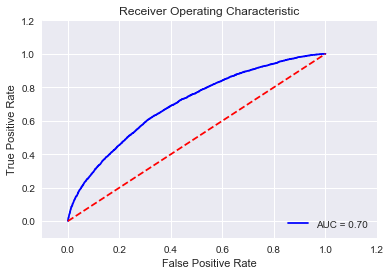

In [57]:
# Compute the FPR, TPR
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

# Plot an ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Part G3 - Look at the initial confusion matrix

In [58]:
y_array = np.array(y_train)
confusion_output = metrics.confusion_matrix(y_array, predicts)
#print (confusion_output)
true_positive = confusion_output[1][0] # student enrolled and we predicted they would enroll
false_positive = confusion_output[1][1] # student enrolled and we predicted they wouldn't enroll
true_negative = confusion_output[0][0] # student didn't enroll and we predicted they wouldn't enroll
false_negative = confusion_output[0][1] # student didn't enroll and we predicted they would enroll 
precision = true_positive * 1.0 / (true_positive + false_positive)
recall = true_positive * 1.0 / (true_positive + false_negative)
f_score = (precision * recall * 2.0) / (precision + recall)

print ('Of the',true_positive+false_positive,'students who enrolled at the UW, we correctly predicted',true_positive,'of them')
print ('Of the',true_positive+false_negative,'students who we predicted would enroll at the UW',true_positive,'of them did')
if detailed_accuracy_metrics:
    print ('True positive',true_positive,', False Positive',false_positive)
    print ('True negative',true_negative,', False Negative',false_negative)
    print ('Precision:',precision,'Recall:', recall, 'F-Score:',f_score)

('Of the', 8055, 'students who enrolled at the UW, we correctly predicted', 5821, 'of them')
('Of the', 6090, 'students who we predicted would enroll at the UW', 5821, 'of them did')
('True positive', 5821, ', False Positive', 2234)
('True negative', 45233, ', False Negative', 269)
('Precision:', 0.7226567349472377, 'Recall:', 0.9558292282430213, 'F-Score:', 0.82304701307882644)


#### Results Tracking

* Store in a Google sheet, https://docs.google.com/a/uw.edu/spreadsheets/d/1ne3dhmafyKZQNlTm7dlONYXvflGP-r3K-CeHfnOO6Qw/edit?usp=sharing 


## Part H - Propensity Score Matching

### Resources

**Highly Useful Code and Guides**

* https://stats.stackexchange.com/questions/206832/matched-pairs-in-python-propensity-score-matching
* https://www.quora.com/Where-can-I-find-a-good-writeup-about-propensity-models


**Code**
* http://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb
* https://github.com/laurencium/causalinference
* https://github.com/MacHu-GWU/ctmatching-project

**Documentation/Guides**
* http://laurence-wong.com/software/


### Steps
* Predict the probabilities
* Split into buckets
* Visualize the causal factor of each bucket

In [32]:
# Predict the probabilities
predictions = clf.predict_proba(x)

#sns.jointplot(x="tuition_after_grants", y="IsEnrolledOrMatriculated", data=df);

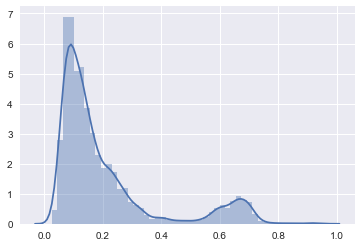

In [33]:
# Visualize the probabilities
sns.distplot(predictions[:, 1], hist=True, rug=False);

In [34]:
predict_df = df_3.copy(deep=True)
predict_df['PropensityScore'] = predictions[:, 1]

In [35]:
# Split into buckets
bins = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.4,0.6, 0.8, 1.0]
bin_name = [0,1,2,3,4,5,6,7,8,9]

In [37]:
predict_df['PropensityBin'] = pd.cut(predict_df['PropensityScore'], bins, labels=bin_name)

#### Use the CausalInference library
* https://github.com/laurencium/causalinference/blob/master/docs/tex/vignette.pdf

In [38]:
#causal = CausalModel(Y, D, X)
# Y 'an N-vector of observed outcomes'
# D 'an N-vector of treatment status indicators'
# X 'an N-by-K matrix of covariates'

In [64]:
d_causal = predict_df.IsEnrolledOrMatriculated
y_causal = predict_df.PropensityScore

x_causal = predict_df.copy()
x_causal.drop('PropensityScore', axis=1, inplace=True)
x_causal.drop('PropensityBin', axis=1, inplace=True)
x_causal.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)
x_causal.drop('finaid_FIN1 - No FAFSA', axis=1, inplace=True)
x_causal.drop('finaid_FIN2 - $0 Needed', axis=1, inplace=True)
x_causal.drop('finaid_FIN3 - $1 - $15K Needed', axis=1, inplace=True)
x_causal.drop('finaid_FIN4 - $15K - $30K Needed', axis=1, inplace=True)
x_causal.drop('finaid_FIN5 - $30K - $40K Needed', axis=1, inplace=True)
x_causal.drop('finaid_FIN6 - $40K+ Needed', axis=1, inplace=True)
x_causal.drop('acad_ACAD1 - 1106 SAT', axis=1, inplace=True)
x_causal.drop('acad_ACAD2 - 1258 SAT', axis=1, inplace=True)
x_causal.drop('acad_ACAD3 - 1283 SAT', axis=1, inplace=True)
x_causal.drop('acad_ACAD4 - 1297 SAT', axis=1, inplace=True)
x_causal.drop('acad_ACAD5 - 1314 SAT', axis=1, inplace=True)
x_causal.drop('acad_ACAD6 - 1327 SAT', axis=1, inplace=True)
x_causal.drop('acad_ACAD7 - 1350 SAT', axis=1, inplace=True)
x_causal.drop('acad_ACAD8 - 1451 SAT', axis=1, inplace=True)
x_causal.drop('TuitionRemaining', axis=1, inplace=True)
x_causal.drop('TotalBudgetRemaining', axis=1, inplace=True)
#x_causal.drop('tuition_after_grants', axis=1, inplace=True)
x_causal.drop('HighSchoolGPA', axis=1, inplace=True)
x_causal.drop('TestScore', axis=1, inplace=True)
x_causal.drop('Fisap_Income', axis=1, inplace=True)
#x_causal.drop('EFC', axis=1, inplace=True)
x_causal.drop('ed_0', axis=1, inplace=True)
x_causal.drop('ed_1', axis=1, inplace=True)
x_causal.drop('ed_2', axis=1, inplace=True)
x_causal.drop('ed_3', axis=1, inplace=True)
x_causal.drop('ed_4', axis=1, inplace=True)
x_causal.drop('ed_5', axis=1, inplace=True)
x_causal.drop('ed_6', axis=1, inplace=True)

print (x_causal.columns)

Index(['EFC', 'AcademicScore', 'tuition_after_grants'], dtype='object')


In [67]:
causal = CausalModel(y_causal, d_causal, x_causal.as_matrix())

C:\Users\fractals.000\AppData\Local\Continuum\Anaconda3\lib\site-packages\causalinference\core\data.py:58: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  self._dict['X_c'] = X[self._dict['controls']]
C:\Users\fractals.000\AppData\Local\Continuum\Anaconda3\lib\site-packages\causalinference\core\data.py:59: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  self._dict['X_t'] = X[self._dict['treated']]
C:\Users\fractals.000\AppData\Local\Continuum\Anaconda3\lib\site-packages\causalinference\core\summary.py:110: RuntimeWarning: invalid value encountered in true_divide
  return (mean_t-mean_c) / np.sqrt((sd_c**2+sd_t**2)/2)


In [68]:
# Summary stats
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=5208)        Treated (N_t=1375)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.159        0.126        0.387        0.238        0.228

                      Controls (N_c=5208)        Treated (N_t=1375)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0     3813.461     1729.392     1336.539     1729.392       -1.432
             X1        0.761        0.202        0.471        0.202       -1.432
             X2    34143.000        0.000    34143.000        0.000          nan



In [69]:
# Propensity scoring
causal.est_propensity_s()
print (causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      1.612      0.066     24.558      0.000      1.484      1.741
            X0     -0.001      0.000    -23.463      0.000     -0.001     -0.001



C:\Users\fractals.000\AppData\Local\Continuum\Anaconda3\lib\site-packages\causalinference\core\propensity.py:24: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  Z_c, Z_t = Z[data['controls']], Z[data['treated']]


In [70]:
causal.propensity.keys()

dict_keys(['qua', 'se', 'loglike', 'fitted', 'coef', 'lin'])

In [71]:
causal.est_via_ols()
causal.est_via_weighting()
#causal.est_via_blocking()
#causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.200      0.008     25.076      0.000      0.185      0.216

Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.214      0.007     30.284      0.000      0.201      0.228
           ATC      0.198      0.034      5.791      0.000      0.131      0.265
           ATT      0.339      0.107      3.184      0.001      0.130      0.548



C:\Users\fractals.000\AppData\Local\Continuum\Anaconda3\lib\site-packages\causalinference\estimators\weighting.py:36: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  weights[D==0] = 1/(1-pscore[D==0])
C:\Users\fractals.000\AppData\Local\Continuum\Anaconda3\lib\site-packages\causalinference\estimators\weighting.py:37: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  weights[D==1] = 1/pscore[D==1]


In [79]:
dir (causal.estimates)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dict',
 'get',
 'iteritems',
 'keys']